In [1]:
# Install necessary Python packages using pip
!pip install -U -q evaluate transformers datasets accelerate mlflow 2>/dev/null



The system cannot find the path specified.


In [2]:
# Import necessary libraries and modules
import warnings
warnings.filterwarnings("ignore")
import gc
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from imblearn.over_sampling import RandomOverSampler
from datasets import Dataset, ClassLabel
from transformers import TrainingArguments, Trainer, ViTImageProcessor, ViTForImageClassification
import torch
from torchvision.transforms import Compose, Normalize, RandomRotation, RandomHorizontalFlip, RandomAdjustSharpness, Resize, ToTensor
from PIL import Image, ImageFile



In [3]:
# Enable the option to load truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True



In [4]:
# Load and prepare dataset
import os
from pathlib import Path

base_path = Path('C:/Users/osyed/OneDrive/Desktop/FacialEmotionRecognition/images/images')
if not base_path.exists():
    raise FileNotFoundError(f"The directory {base_path} does not exist. Please check the path.")

file_names, labels, images = [], [], []
for file in sorted(base_path.glob('*/*/*.*')):
    labels.append(file.parts[-2])
    file_names.append(str(file))
    with Image.open(file) as image:
        image = image.convert("RGB")
        images.append(image)



In [5]:
# Create DataFrame
df = pd.DataFrame({"image": images, "label": labels})
df['label'] = df['label'].astype('category')



In [6]:
# Perform random oversampling
y = df[['label']]
df = df.drop(['label'], axis=1)
ros = RandomOverSampler(random_state=83)
df, y_resampled = ros.fit_resample(df, y)
df['label'] = y_resampled



In [50]:
# Get all unique labels from the 'label' column of your DataFrame
unique_labels = df['label'].unique()

# Print the unique labels
print("Unique labels:", unique_labels)


Unique labels: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Categories (7, object): ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [7]:
# Convert to dataset
dataset = Dataset.from_dict({"image": df["image"].tolist(), "label": df["label"].tolist()})



In [8]:
# Define label mappings
labels_list = df['label'].unique().tolist()
label2id, id2label = {label: i for i, label in enumerate(labels_list)}, {i: label for i, label in enumerate(labels_list)}
class_labels = ClassLabel(num_classes=len(labels_list), names=labels_list)
dataset = dataset.map(lambda example: {'label': class_labels.str2int(example['label'])}, batched=True)
dataset = dataset.cast_column('label', class_labels)



Map:   0%|          | 0/62923 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/62923 [00:00<?, ? examples/s]

In [9]:
# Split dataset
dataset = dataset.train_test_split(test_size=0.7, shuffle=True, stratify_by_column="label")
train_data, test_data = dataset['train'], dataset['test']



In [10]:
# Define image transformations
model_str = "dima806/facial_emotions_image_detection"
processor = ViTImageProcessor.from_pretrained(model_str)
normalize = Normalize(mean=processor.image_mean, std=processor.image_std)
size = processor.size["height"]



In [11]:
_train_transforms = Compose([
    Resize((size, size)),
    RandomRotation(90),
    RandomAdjustSharpness(2),
    RandomHorizontalFlip(0.5),
    ToTensor(),
    normalize
])



In [12]:
_val_transforms = Compose([
    Resize((size, size)),
    ToTensor(),
    normalize
])



In [13]:
def train_transforms(examples):
    examples["pixel_values"] = [_train_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples



In [14]:
def val_transforms(examples):
    examples["pixel_values"] = [_val_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples



In [15]:
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)



In [16]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example['label'] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}



In [17]:
# Load and prepare model
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))
model.config.id2label = id2label
model.config.label2id = label2id



In [18]:
# Define compute metrics function
import evaluate
accuracy = evaluate.load("accuracy")



In [19]:
def compute_metrics(eval_pred):
    predictions = eval_pred.predictions.argmax(axis=1)
    label_ids = eval_pred.label_ids
    acc_score = accuracy.compute(predictions=predictions, references=label_ids)['accuracy']
    return {"accuracy": acc_score}



In [20]:
# Define training arguments
args = TrainingArguments(
    output_dir="facial_emotions_image_detection",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.02,
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="none"
)



In [21]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)



In [22]:
# Train and evaluate model
trainer.train()
trainer.evaluate()



Epoch,Training Loss,Validation Loss,Accuracy
1,1.340000,0.778570,0.718732
2,0.915800,0.698579,0.754081
3,0.822900,0.622218,0.785343
4,0.752200,0.585983,0.797648
5,0.691700,0.578970,0.800736


{'eval_loss': 0.5789695978164673,
 'eval_accuracy': 0.8007355779054192,
 'eval_runtime': 14908.789,
 'eval_samples_per_second': 2.954,
 'eval_steps_per_second': 0.369,
 'epoch': 5.0}

In [25]:
# Save the trained model
trainer.save_model()

In [43]:

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")



Accuracy: 0.8007
F1 Score: 0.7997


In [32]:

import seaborn as sns
import matplotlib.pyplot as plt

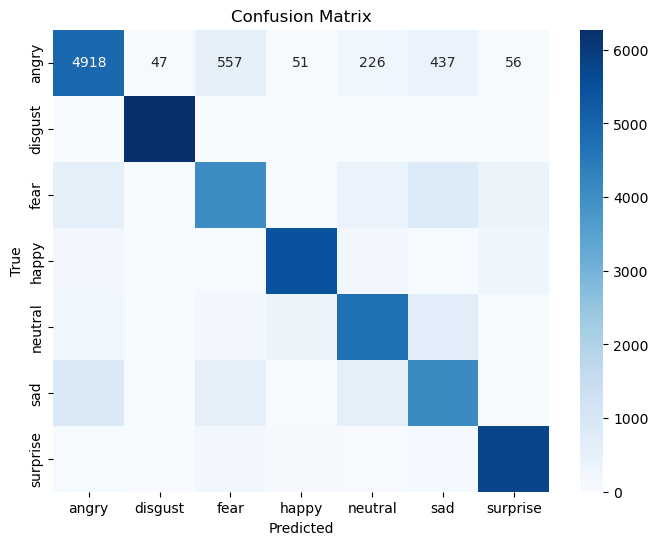

In [33]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=labels_list, yticklabels=labels_list)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [37]:
print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))




Classification report:

              precision    recall  f1-score   support

       angry     0.7101    0.7816    0.7441      6292
     disgust     0.9831    0.9970    0.9900      6292
        fear     0.7193    0.6417    0.6783      6293
       happy     0.9015    0.8668    0.8838      6292
     neutral     0.7595    0.7496    0.7545      6293
         sad     0.6557    0.6496    0.6526      6293
    surprise     0.8721    0.9189    0.8949      6292

    accuracy                         0.8007     44047
   macro avg     0.8002    0.8007    0.7997     44047
weighted avg     0.8002    0.8007    0.7997     44047



In [34]:
# Code to use the saved model to predict emotions using live cam
import cv2



In [35]:
# Load the saved model
model = ViTForImageClassification.from_pretrained("facial_emotions_image_detection")
model.config.id2label = id2label
model.config.label2id = label2id



In [ ]:
# Initialize the camera
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    inputs = processor(img, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits
    prediction = logits.argmax(-1).item()
    emotion = id2label[prediction]
    cv2.putText(frame, emotion, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    cv2.imshow('Emotion Detection', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [42]:
# Define the new directory and file name for the saved model
new_model_path = "C:/Users/osyed/OneDrive/Desktop/VIT2Model"

# Save the model with the new name
trainer.save_model(new_model_path)
